In [5]:
# get data

import pandas as pd

df = pd.read_csv('testdata/data_combined_24.csv', sep=',', names=["Category", "Sentence"])

# randomly sample data uniformly across categories
sampled = df.groupby('Category', group_keys=False).apply(lambda x: x.sample(min(len(x), 100)))
print(len(sampled))

df.head()

# print all unique categories

print(sampled['Category'].unique())

2300
['business' 'computerscience' 'culture' 'disasters' 'economics'
 'education' 'entertainment' 'foods' 'geography' 'history' 'law'
 'mathematics' 'medicine' 'music' 'nature' 'news' 'philosophy' 'politics'
 'religion' 'science' 'sports' 'technology' 'videogames']


In [7]:
#convert text into BERT features

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

best_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
best_model = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1")

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = best_preprocess(text_input)
outputs = best_model(preprocessed_text)

l = tf.keras.layers.Dropout(0.1, name='dropout')(outputs['pooled_output'])
#run a sentence through the model to see what the output looks like

model = tf.keras.Model(inputs=[text_input], outputs = [l])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [8]:
#get features of all sentences in df
# add features to df

import numpy as np

features = model.predict(list(sampled.Sentence.to_numpy()))


#add features to df, create 512 feature columns



72/72 [==============================] - 120s 2s/step


In [9]:
for i in range(512):
    sampled['feature'+str(i)] = features[:,i]

sampled.head()

C:\Users\jfitz\AppData\Local\Temp\ipykernel_39736\3420900657.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sampled['feature'+str(i)] = features[:,i]
C:\Users\jfitz\AppData\Local\Temp\ipykernel_39736\3420900657.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sampled['feature'+str(i)] = features[:,i]
C:\Users\jfitz\AppData\Local\Temp\ipykernel_39736\3420900657.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider j

,Category,Sentence,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,...,feature502,feature503,feature504,feature505,feature506,feature507,feature508,feature509,feature510,feature511
27400,business,a person analysis identifies which individuals...,0.921814,0.306270,0.325673,0.305865,0.416903,0.949471,0.987223,-0.774793,...,-0.189081,0.044996,0.531446,-0.719306,0.876758,0.939155,0.467248,-0.152331,-0.489618,-0.807827
27455,business,individual contributors who perform team tasks...,0.965421,-0.516696,-0.022708,0.327777,0.404811,0.990883,0.985033,-0.992516,...,-0.441232,0.167869,0.362256,-0.605099,0.259914,0.902201,0.105249,-0.074544,-0.437357,-0.540914
27146,business,nominees international olympic committee 2009 ...,0.358721,0.857194,0.054314,0.212385,0.432933,-0.129761,0.999001,-0.963843,...,-0.294890,0.299321,0.455865,-0.786917,0.437404,-0.427168,0.547889,-0.363918,-0.541971,-0.666810
27765,business,formal requirements and advertising status the...,0.990252,0.019462,-0.076567,-0.112311,-0.030570,0.994167,0.997938,-0.995200,...,0.263141,-0.210326,0.219870,-0.752668,-0.070880,0.242665,0.412546,-0.475430,-0.154762,-0.917708
27836,business,dissolution causes common to all societieschec...,0.983786,-0.577422,0.074596,-0.128610,-0.250815,0.980768,0.998612,-0.979963,...,-0.199966,0.028603,0.204253,-0.848257,0.142120,0.474908,0.338580,-0.064152,-0.032776,-0.515952


In [33]:
#perform PCA on features

# filter for categories geography and nature

df_pca = sampled[sampled.Category.isin(['religion', 'philosophy'])]
categories = df_pca[['Category']]
categories = categories.reset_index(drop=True)

from sklearn.decomposition import PCA

pca = PCA(n_components=114)
principalComponents = pca.fit_transform(df_pca.iloc[:,114:])
principalDf = pd.DataFrame(data = principalComponents, columns = [f'pc{i}' for i in range(1,115)])

principalDf.head()

print(categories)
print(principalDf)


       Category
0    philosophy
1    philosophy
2    philosophy
3    philosophy
4    philosophy
..          ...
195    religion
196    religion
197    religion
198    religion
199    religion

[200 rows x 1 columns]
          pc1       pc2       pc3       pc4       pc5       pc6       pc7  \
0    7.534074  0.608044 -2.049134 -2.423969 -0.107973  0.168916 -0.526812   
1   -3.249231 -1.991136 -0.879064  1.106521  3.459138  2.340505  0.923885   
2   -4.039273 -3.761559 -0.100327 -1.156624 -0.609062 -0.157535 -0.384429   
3   -2.392782 -2.446970 -0.871672 -0.276168 -0.260772  0.529766 -0.696744   
4   -3.163964  0.353623 -1.283581  1.103397  1.105168 -2.135618 -0.749526   
..        ...       ...       ...       ...       ...       ...       ...   
195 -3.831984  0.320815 -1.108360  1.304657 -2.470643  1.505786 -0.707309   
196 -2.038768 -0.565565 -2.856055 -0.765793 -1.579345 -0.720563  0.980911   
197 -2.859166 -1.531202  0.246612 -0.619218 -1.798530  0.068871 -0.084211   
198  3.400098 

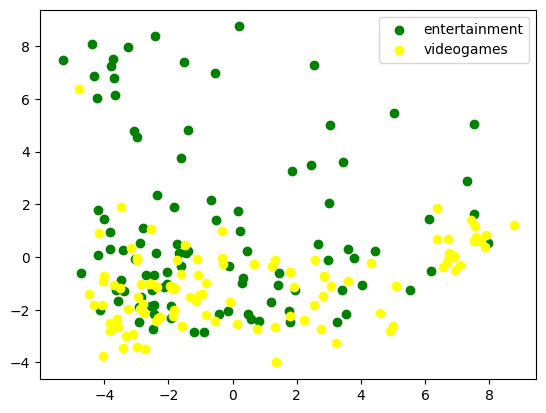

In [34]:
#plot top 2 PCs and color by category

import matplotlib.pyplot as plt

finalDf = pd.concat([principalDf, categories], axis = 1)

finalDf.head()

# get list of points for geography and nature
geography = finalDf[finalDf.Category == 'religion']
nature = finalDf[finalDf.Category == 'philosophy']

#randomly sample 100 points from each category
geography = geography.sample(n=100)
nature = nature.sample(n=100)

# plot points
plt.scatter(geography.pc1, geography.pc2, color='green')
plt.scatter(nature.pc1, nature.pc2, color='yellow')

#add a legend
plt.legend(['entertainment', 'videogames'])

plt.show()




In [35]:
#check linear seperability of the 2 categories using a perceptron

from sklearn.linear_model import Perceptron

#shuffle data
finalDf = finalDf.sample(frac=1).reset_index(drop=True)

#split into train and test
train = finalDf.iloc[:int(len(finalDf)*0.8),:]
test = finalDf.iloc[int(len(finalDf)*0.8):,:]

perceptron = Perceptron()

#test perceptron on 2 categories
perceptron.fit(train.iloc[:,0:114], train.Category)


#check accuracy
perceptron.score(test.iloc[:,0:114], test.Category)



0.725